<a href="https://colab.research.google.com/github/VegaSera/World-Archery-Analysis/blob/master/World_Archery_Exploration_and_Arrow_Averages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import requests
from statistics import mean

In [0]:
#There are 10 different competition levels.
#1 - Olympics
#2 - World Championships
#3 - World Cup
#4 - Multisport World Event
#5 - Multisport Continental Event
#6 - Continental Championships
#7 - International Event Circuits
#8 - Other International Event
#9 - National Championships
#10 - National Competition
#2016 had no Multisport events, or events on the International Event Circuits.
#Since we're looking to see arrow average trends before and after the olympics, we may need to do only specific competition levels

In [0]:
#Global Variables
category = 'RM' #Can only be RM, CM, RW, CW

In [0]:
def make_competition_json(year): 
  #Creates a json file for a competition year
  #Output json file will include all competitions within a given year that have results in them.

  json_type = "COMPETITIONS"

  request_data = requests.get(f'https://api.worldarchery.org/v3/COMPETITIONS/?StartDate={year}-01-01&EndDate={year}-12-31&WithResults=1&RBP=999999')
  json_data = request_data.json()

  pathname = f'{json_type}'
  filename = f'{pathname}/COMP_{year}.json' #Dynamic naming

  if os.path.exists(filename): #Check to see if it already exists
    print('File ' + filename + ' already exists!')
  else:
    if not os.path.exists(pathname): #If the directory does not exist, then make it.
      os.makedirs(pathname)
    with open(filename, 'w') as f:
      json.dump(json_data, f)
      print("File " + filename + " has been created.")


In [0]:
def make_match_json(comp, year, cat=None): 
  #Creates a json file for an individual match.
  #Requires a competition id and a year, category is optional but recommended
  #Output json will include all individual matches for a given competition.

  json_type = "INDIVIDUALMATCHES" #This function is purely for individual matches.
  CatUrlCode = '' #Empty category code URL piece by default. Only gets filled in if a category code has been specified.
  if cat is not None: #Cat has been specified, and is preferred, but is not required. 
    if cat in ['CM', 'CW', 'RM', 'RW']: #This is only a small subsection of the 200 possible codes. We only care about Compound and Recurve for Men and Women.
      CatUrlCode = f'&CatCode={cat}'
    else: #Obligatory unexpected cat response.
      print('You gave me a weird cat. Category that is. CM, CW, RM, RW only.')

  #Move the below into the if/else statement to stop pinging the API server repeatedly
  request_data = requests.get(f'https://api.worldarchery.org/v3/INDIVIDUALMATCHES/?CompId={comp}{CatUrlCode}&RBP=999999')
  json_data = request_data.json()

  if sys.getsizeof(str(json_data)) < 200: #Checking for a nearly empty file.
    print (f"File {json_type}/{year}_{comp}_{cat}.json - Rejected Due to File Size")
  else:
    pathname = f'{json_type}'
    filename = f'{pathname}/{year}_{comp}_{cat}.json'
    if os.path.exists(filename):
      pass
      #print('File ' + filename + ' already exists!')
    else:
      if not os.path.exists(pathname): #If the directory does not exist, then make it.
        os.makedirs(pathname)
      with open(filename, 'w') as f:
        json.dump(json_data, f)
        print("File " + filename + " has been created.")

In [0]:
def arrow_string_to_list(x):
  #Takes a list of arrows scores in a string, returns it as a list of integers, and checks for X scores.
  #Original data is in a format like '9,10,10,10,9*,X,10,X,10'
  #Returns a python list of integers matching the value of the input.
  
  if type(x) != type(np.NaN): #Our missing values for .ArrTB are empty strings.
    x = x.lower().replace("m", "0") #An M indicates a miss, 0 points.
    x = x.lower().replace("*", "") #* indicates that an arrow may have touched the line between rings, and could be marked up. We cannot determine if it has been or not, so we will assume it hasn't been.
    x = x.lower().replace("x","10").split(',') #First makes sure that both capital and lower case Xs get changed, then changes it to a 10 string. and is now a list of strings.
    strlist = [int(i) for i in x] #converts all the strings to ints.
    return strlist
  else:
    return np.NaN


In [0]:
def arrow_list_df(json_file):
  #Function takes a competition json and first validates it.
  #Then it calls the arrow_string_to_list() function to numerical values we can work with.
  #Returns a dataframe with the necessary values.

  if os.path.exists(json_file):
    x = json.load(open(json_file))
    im1 = json_normalize(data=x['items'], record_path='Matches', meta='Code')
    #From the above we need TimeStamp, Competitor1.Arr, Competitor2.Arr, Competitor1.ArrTB, Competitor2.ArrTB
    if sys.getsizeof(str(im1['Competitor1.Arr'])) > 370: #Relatively certain there is data in the Arrow data.
      im1 = im1.replace(r'^\s*$', np.nan, regex=True) #Replaces records with spaces and empty strings with np.NaN
      Comp1Arr = im1['Competitor1.Arr'].apply(arrow_string_to_list)
      Comp2Arr = im1['Competitor2.Arr'].apply(arrow_string_to_list)
      Comp1ArrTB = im1['Competitor1.ArrTB'].apply(arrow_string_to_list)
      Comp2ArrTB = im1['Competitor2.ArrTB'].apply(arrow_string_to_list)
      df = pd.DataFrame(data=[im1['TimeStamp'], Comp1Arr, Comp1ArrTB, Comp2Arr, Comp2ArrTB])
      print(f'File {json_file} accepted. Competitor1.Arr Size = ' + str(sys.getsizeof(str(im1['Competitor1.Arr']))))
      return df.transpose()
    else: #Data in Competitor1.Arr was too small. Likely missing.
      return np.NaN #We'll check to see if the returned value is a NaN, and if it is, ignore the next bit of processing.
  else: #File path did not exist, file must have been too small.
    return np.NaN 

In [0]:
def arrow_average(df):
  #Takes a dataframe row
  #Checks if the value is a np.NaN by checking to see if it is not equal to itself
  #If value is equal to itself, it adds up all of the arrows for the given competitor
  #and finally returns the new Comp#MatchAvg columns with the actual match average.
  df2 = df
  df2['Comp1MatchAvg'] = df2[['Competitor1.Arr','Competitor1.ArrTB']].applymap(lambda x: [] if x != x else x).apply(np.sum, axis=1); df2['Comp1MatchAvg'] #np.NaN does not equal itself, so this lambda will replace NaNs with an empty list.
  df2 = df2[df2['Comp1MatchAvg'].map(len) > 0]
  df2['Comp1MatchAvg'] = df2['Comp1MatchAvg'].apply(mean)
  df2['Comp2MatchAvg'] = df2[['Competitor2.Arr','Competitor2.ArrTB']].applymap(lambda x: [] if x != x else x).apply(np.sum, axis=1); df2['Comp2MatchAvg']
  df2 = df2[df2['Comp2MatchAvg'].map(len) > 0]
  df2['Comp2MatchAvg'] = df2['Comp2MatchAvg'].apply(mean)
  return df2

Okay, so what we've achieved so far is we are able to get a list of events that happened in 2016 (COMPETITIONS_2016), and we are able to use the ID from that dataframe to call the API to provide us with the dataframe of the matches that event had.

After several failures, we had to add a file length check to make sure we weren't getting empty data, and a check to make sure that arrow data existed.

From the match, we can get individual arrow scores and compute the average arrow value for that match per competitor. And from that we can get the min/max/mean arrow average for that competition as a whole.

##What needs to happen now

Now that we have the support to quickly come up with arrow averages, we iterate over our list of competitions (except the olympics) and see if we can determine any trends. We may need multiple years to determine if there is an abnormal spike or dip during the olympics.

In [0]:
def process_year(year, cat): #Starter functions meant to begin the full processing for a year all the way to ArrAvg stats.
  make_competition_json(year)
  data = json.load(open(f'COMPETITIONS/COMP_{year}.json'))
  competition = pd.DataFrame(data['items'])

  condition = ((competition['ComLevel'].isin([2, 3, 4, 5, 6, 7])) & (~competition['ComSubLevel'].isin([7, 8, 14, 15, 16, 17, 35, 36, 51, 52]))) #excluding olympics and all indoor archery, field archery and 3d archery
  comp_data = pd.DataFrame(columns=["TimeStamp", "Competition_ID", "Competition_Name", "CompArrAvg_Mean", "CompArrAvg_Min", "CompArrAvg_Max", "CompArrAvg_Std"])
  for event in competition[condition].itertuples():
    Comp_ID = event[1]
    Comp_Name = event[2]
    #timeStamp = event[8]
    make_match_json(Comp_ID, cat=cat, year=year)
    df = arrow_list_df(f'INDIVIDUALMATCHES/{year}_{Comp_ID}_{cat}.json')
    if isinstance(df, pd.DataFrame): #This ensures we got back a dataframe from our arrow_list_df
      df = arrow_average(df)
      timeStamp = pd.to_datetime(df['TimeStamp'][0], unit='s') #Time of the match isn't an exact thing, it seems to be the time that the record was created rather than the time of the match. We take just the first and convert it from unix time.
      timeStamp_doy = timeStamp.dayofyear
      timeStamp_m = timeStamp.month
      arrow_avgs = df["Comp1MatchAvg"].append(df["Comp2MatchAvg"])
      Avg_Mean = arrow_avgs.mean()
      Avg_Min = arrow_avgs.min()
      Avg_Max = arrow_avgs.max()
      Avg_Std = arrow_avgs.std()
      dat = pd.Series(data=[timeStamp, timeStamp_doy, timeStamp_m, Comp_ID, Comp_Name, Avg_Mean, Avg_Min, Avg_Max, Avg_Std], index=["TimeStamp", "TimeStamp_doy", "TimeStamp_m", "Competition_ID", "Competition_Name", "CompArrAvg_Mean", "CompArrAvg_Min", "CompArrAvg_Max", "CompArrAvg_Std"])
      comp_data = comp_data.append(other=dat, ignore_index=True)
    else: #We got an np.NaN from a bad event, skipping it.
      print(f'File INDIVIDUALMATCHES/{year}_{Comp_ID}_{cat}.json - Rejected')
      continue
  return comp_data


In [0]:
df_2016 = process_year('2016', category)
df_2016 = df_2016.sort_values('TimeStamp_doy')
#df_2016 = df_2016.drop(3)
df_2016


File COMPETITIONS/COMP_2016.json has been created.
File INDIVIDUALMATCHES/2016_16144_RM.json has been created.
File INDIVIDUALMATCHES/2016_16144_RM.json accepted. Competitor1.Arr Size = 421
File INDIVIDUALMATCHES/2016_14313_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2016_14313_RM.json - Rejected
File INDIVIDUALMATCHES/2016_14312_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2016_14312_RM.json - Rejected
File INDIVIDUALMATCHES/2016_14531_RM.json has been created.
File INDIVIDUALMATCHES/2016_14531_RM.json accepted. Competitor1.Arr Size = 604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2016_14309_RM.json has been created.
File INDIVIDUALMATCHES/2016_14309_RM.json accepted. Competitor1.Arr Size = 570
File INDIVIDUALMATCHES/2016_14869_RM.json has been created.
File INDIVIDUALMATCHES/2016_14869_RM.json accepted. Competitor1.Arr Size = 1397
File INDIVIDUALMATCHES/2016_14530_RM.json has been created.
File INDIVIDUALMATCHES/2016_14530_RM.json accepted. Competitor1.Arr Size = 604
File INDIVIDUALMATCHES/2016_14529_RM.json has been created.
File INDIVIDUALMATCHES/2016_14529_RM.json accepted. Competitor1.Arr Size = 571
File INDIVIDUALMATCHES/2016_14528_RM.json has been created.
File INDIVIDUALMATCHES/2016_14528_RM.json accepted. Competitor1.Arr Size = 615
File INDIVIDUALMATCHES/2016_14307_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2016_14307_RM.json - Rejected
File INDIVIDUALMATCHES/2016_14876_RM.json has been created.
File INDIVIDUALMATCHES/2016_14876_RM.json - Rejected


,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
6,2016-05-01 07:38:15,14528,Shanghai 2016 Hyundai Archery World Cup Stage 1,9.137667,8.111111,9.777778,0.316199,122.0,5.0
5,2016-05-15 21:36:08,14529,Medellin 2016 Hyundai Archery World Cup Stage 2,9.077059,6.666667,10.000000,0.414851,136.0,5.0
4,2016-05-29 15:29:53,14530,Nottingham 2016 European Archery Championships,8.734322,5.888889,9.888889,0.594686,150.0,5.0
3,2016-06-04 04:44:13,14869,XXIII Pan American and II Para Pan American Ch...,8.318347,5.666667,9.250000,0.712232,156.0,6.0
2,2016-06-05 07:55:25,14309,11th World University Archery Championship,8.655667,6.666667,9.583333,0.538613,157.0,6.0
1,2016-06-19 13:48:25,14531,Antalya 2016 Hyundai Archery World Cup Stage 3,9.143583,7.888889,10.000000,0.321006,171.0,6.0
0,2016-09-25 13:57:14,16144,Odense 2016 Hyundai Archery World Cup Final,9.068056,8.111111,9.666667,0.363727,269.0,9.0


In [0]:
df_2015 = process_year('2015', category)
df_2015 = df_2015.sort_values('TimeStamp_doy')
df_2015

File COMPETITIONS/COMP_2015.json has been created.
File INDIVIDUALMATCHES/2015_14286_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2015_14286_RM.json - Rejected
File INDIVIDUALMATCHES/2015_14280_RM.json has been created.
File INDIVIDUALMATCHES/2015_14280_RM.json accepted. Competitor1.Arr Size = 604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2015_14269_RM.json has been created.
File INDIVIDUALMATCHES/2015_14269_RM.json accepted. Competitor1.Arr Size = 405
File INDIVIDUALMATCHES/2015_14249_RM.json has been created.
File INDIVIDUALMATCHES/2015_14249_RM.json accepted. Competitor1.Arr Size = 593
File INDIVIDUALMATCHES/2015_14240_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2015_14240_RM.json - Rejected
File INDIVIDUALMATCHES/2015_14235_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2015_14235_RM.json - Rejected
File INDIVIDUALMATCHES/2015_14225_RM.json has been created.
File INDIVIDUALMATCHES/2015_14225_RM.json accepted. Competitor1.Arr Size = 549
File INDIVIDUALMATCHES/2015_14221_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2015_14221_RM.json - Rejected
File INDIVIDUALMATCHES/2015_14215_RM.json has been created.
File INDIVIDUALMATCHES/2015_14215_RM.json accepted. Competitor1.Arr Size = 549
File INDIVIDUALMATCHES/2015_14200_RM.json has been created.
File INDIVIDUAL

,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
9,2015-05-10 08:25:44,14102,Shanghai 2015 Archery World Cup Stage 1,9.069625,7.777778,9.777778,0.345089,130.0,5.0
8,2015-05-31 14:08:37,14131,Antalya 2015 Archery World Cup Stage 2,9.091153,7.533333,9.888889,0.349659,151.0,5.0
7,2015-06-22 12:48:01,14155,Baku 2015 European Games,8.939041,6.777778,9.777778,0.471751,173.0,6.0
6,2015-07-08 09:58:05,14182,Gwangju 2015 Summer Universiade,8.966217,6.222222,9.888889,0.452791,189.0,7.0
5,2015-07-19 10:11:08,14200,Toronto 2015 Pan American Games,8.962565,7.666667,9.666667,0.407647,200.0,7.0
4,2015-08-02 16:03:11,14215,Copenhagen 2015 World Archery Championships,8.778913,7.333333,9.777778,0.408053,214.0,8.0
3,2015-08-16 15:13:25,14225,Wroclaw 2015 Archery World Cup Stage 3,8.923992,5.111111,9.666667,0.514045,228.0,8.0
2,2015-09-12 21:36:48,14249,Medellin 2015 Archery World Cup Stage 4,8.988729,4.555556,9.666667,0.518289,255.0,9.0
1,2015-10-25 23:09:47,14269,Mexico City 2015 Archery World Cup Final,9.222396,8.583333,9.666667,0.264378,298.0,10.0
0,2015-11-08 11:19:14,14280,Bangkok 2015 Asian Archery Championships + CQT,8.916675,5.888889,9.833333,0.561951,312.0,11.0


In [0]:
df_2017 = process_year('2017', category)
df_2017 = df_2017.sort_values('TimeStamp_doy')
df_2017

File COMPETITIONS/COMP_2017.json has been created.
File INDIVIDUALMATCHES/2017_17824_RM.json has been created.
File INDIVIDUALMATCHES/2017_17824_RM.json accepted. Competitor1.Arr Size = 571


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2017_17436_RM.json has been created.
File INDIVIDUALMATCHES/2017_17436_RM.json accepted. Competitor1.Arr Size = 1397
File INDIVIDUALMATCHES/2017_14538_RM.json has been created.
File INDIVIDUALMATCHES/2017_14538_RM.json accepted. Competitor1.Arr Size = 571
File INDIVIDUALMATCHES/2017_16586_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2017_16586_RM.json - Rejected
File INDIVIDUALMATCHES/2017_15796_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2017_15796_RM.json - Rejected
File INDIVIDUALMATCHES/2017_15807_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2017_15807_RM.json - Rejected
File INDIVIDUALMATCHES/2017_17403_RM.json has been created.
File INDIVIDUALMATCHES/2017_17403_RM.json accepted. Competitor1.Arr Size = 453
File INDIVIDUALMATCHES/2017_17021_RM.json has been created.
File INDIVIDUALMATCHES/2017_17021_RM.json accepted. Competitor1.Arr Size = 582
File INDIVIDUALMATCHES/2017_15470_RM.json has been created.
File INDIVIDUA

,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
8,2017-05-21 07:45:43,15914,Shanghai 2017 Hyundai Archery World Cup Stage 1,9.013170,6.666667,9.833333,0.411845,141.0,5.0
7,2017-06-11 13:40:31,15915,Antalya 2017 Hyundai Archery World Cup Stage 2,9.061427,7.222222,9.888889,0.363727,162.0,6.0
6,2017-06-25 22:45:13,16212,Salt Lake City 2017 Hyundai Archery World Cup ...,8.839270,7.222222,9.777778,0.482280,176.0,6.0
5,2017-08-13 12:32:29,15470,Berlin 2017 Hyundai Archery World Cup Stage 4,9.122803,8.111111,9.833333,0.337355,225.0,8.0
4,2017-08-24 11:39:29,17021,Taipei 2017 Summer Universiade,8.780372,6.000000,10.000000,0.540887,236.0,8.0
3,2017-09-03 14:43:13,17403,Rome 2017 Hyundai Archery World Cup Final,9.229861,8.333333,9.777778,0.456083,246.0,9.0
2,2017-10-22 21:38:16,14538,Mexico City 2017 Hyundai World Archery Champio...,9.111806,7.777778,9.777778,0.342647,295.0,10.0
1,2017-11-16 21:17:49,17436,XVIII Juegos Bolivarianos,8.785243,6.888889,9.666667,0.578524,320.0,11.0
0,2017-11-30 11:06:12,17824,Dhaka 2017 Asian Archery Championships & CQT f...,8.862298,4.555556,9.750000,0.664713,334.0,11.0


In [0]:
df_2018 = process_year('2018', category)
df_2018 = df_2018.sort_values('TimeStamp_doy')
df_2018

File COMPETITIONS/COMP_2018.json has been created.
File INDIVIDUALMATCHES/2018_19286_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19286_RM.json - Rejected
File INDIVIDUALMATCHES/2018_19186_RM.json has been created.
File INDIVIDUALMATCHES/2018_19186_RM.json accepted. Competitor1.Arr Size = 445
File INDIVIDUALMATCHES/2018_19259_RM.json has been created.
File INDIVIDUALMATCHES/2018_19259_RM.json accepted. Competitor1.Arr Size = 593


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2018_15403_RM.json has been created.
File INDIVIDUALMATCHES/2018_15403_RM.json accepted. Competitor1.Arr Size = 548
File INDIVIDUALMATCHES/2018_19713_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19713_RM.json - Rejected
File INDIVIDUALMATCHES/2018_19715_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19715_RM.json - Rejected
File INDIVIDUALMATCHES/2018_19716_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19716_RM.json - Rejected
File INDIVIDUALMATCHES/2018_19717_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19717_RM.json - Rejected
File INDIVIDUALMATCHES/2018_18261_RM.json has been created.
File INDIVIDUALMATCHES/2018_18261_RM.json accepted. Competitor1.Arr Size = 570
File INDIVIDUALMATCHES/2018_19282_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2018_19282_RM.json - Rejected
File INDIVIDUALMATCHES/2018_19308_RM.json has been created.
File INDIVIDUALMATCHES/2018_19308_RM.json accep

,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
13,2018-03-10 15:28:20,18583,Bangkok 2018 Asia Cup Stage 1,8.925393,6.444444,9.888889,0.478833,69.0,3.0
12,2018-04-12 17:59:54,19097,Manila 2018 Asia Cup Stage 2 World Ranking Event,8.905452,7.333333,9.666667,0.408746,102.0,4.0
11,2018-04-29 07:14:25,18142,Shanghai 2018 Hyundai Archery World Cup,9.091513,7.222222,9.888889,0.378380,119.0,4.0
10,2018-05-26 14:00:27,18116,Antalya 2018 Hyundai Archery World Cup,9.151218,8.111111,9.888889,0.346596,146.0,5.0
9,2018-06-25 01:33:56,18117,Salt Lake City 2018 Hyundai Archery World Cup,9.013687,7.888889,9.777778,0.388157,176.0,6.0
7,2018-07-10 15:03:20,19198,Taipei 2018 Asia Cup Stage 3 World Ranking Event,8.724179,5.777778,9.600000,0.670369,191.0,7.0
6,2018-07-22 13:03:10,16078,Berlin 2018 Hyundai Archery World Cup,8.979968,7.916667,9.888889,0.379475,203.0,7.0
8,2018-07-24 10:52:35,18347,Tarragona 2018 XVIII Mediterranean Games,8.562630,4.222222,9.555556,0.851149,205.0,7.0
4,2018-08-05 07:15:11,19308,Sofia 2018 European Grand Prix World Ranking E...,8.870146,7.000000,9.777778,0.441065,217.0,8.0
3,2018-08-20 06:31:33,18261,XXIV Pan American and III Para Pan American Ch...,8.789156,7.111111,9.666667,0.551310,232.0,8.0


In [0]:
df_2014 = process_year('2014', category)

df_2014['TimeStamp_doy'] = pd.Series([249.0, 217.0, 183.0, 161.0, 133.0, 112.0])
df_2014 = df_2014.sort_values('TimeStamp_doy')
df_2014

File COMPETITIONS/COMP_2014.json has been created.
File INDIVIDUALMATCHES/2014_485_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_485_RM.json - Rejected
File INDIVIDUALMATCHES/2014_490_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_490_RM.json - Rejected
File INDIVIDUALMATCHES/2014_13659_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_13659_RM.json - Rejected
File INDIVIDUALMATCHES/2014_508_RM.json has been created.
File INDIVIDUALMATCHES/2014_508_RM.json - Rejected
File INDIVIDUALMATCHES/2014_506_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_506_RM.json - Rejected
File INDIVIDUALMATCHES/2014_503_RM.json has been created.
File INDIVIDUALMATCHES/2014_503_RM.json accepted. Competitor1.Arr Size = 437
File INDIVIDUALMATCHES/2014_500_RM.json has been created.
File INDIVIDUALMATCHES/2014_500_RM.json accepted. Competitor1.Arr Size = 549


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2014_13424_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_13424_RM.json - Rejected
File INDIVIDUALMATCHES/2014_486_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_486_RM.json - Rejected
File INDIVIDUALMATCHES/2014_501_RM.json has been created.
File INDIVIDUALMATCHES/2014_501_RM.json accepted. Competitor1.Arr Size = 559
File INDIVIDUALMATCHES/2014_499_RM.json has been created.
File INDIVIDUALMATCHES/2014_499_RM.json accepted. Competitor1.Arr Size = 560
File INDIVIDUALMATCHES/2014_498_RM.json has been created.
File INDIVIDUALMATCHES/2014_498_RM.json accepted. Competitor1.Arr Size = 604
File INDIVIDUALMATCHES/2014_497_RM.json has been created.
File INDIVIDUALMATCHES/2014_497_RM.json accepted. Competitor1.Arr Size = 571
File INDIVIDUALMATCHES/2014_481_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2014_481_RM.json - Rejected


,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
5,2015-06-03 19:03:58,497,Shanghai 2014 Archery World Cup Stage 1,8.927255,1.888889,9.777778,0.643620,112.0,6.0
4,2015-06-03 19:05:44,498,Medellin 2014 Archery World Cup Stage 2,8.989894,7.000000,9.777778,0.448270,133.0,6.0
3,2015-06-03 19:06:58,499,Antalya 2014 Archery World Cup Stage 3,8.909949,7.777778,9.777778,0.387829,161.0,6.0
2,2015-06-03 18:44:27,501,10th World University Archery Championship,8.939974,7.111111,9.777778,0.436052,183.0,6.0
1,2015-06-03 19:08:24,500,Wroclaw 2014 Archery World Cup Stage 4,9.000574,7.555556,9.888889,0.413211,217.0,6.0
0,2015-06-03 18:17:16,503,Lausanne 2014 Archery World Cup Final,9.228472,8.666667,9.666667,0.320683,249.0,6.0


In [0]:
df_2019 = process_year('2019', category)
df_2019 = df_2019.sort_values('TimeStamp_doy')
df_2019

File COMPETITIONS/COMP_2019.json has been created.
File INDIVIDUALMATCHES/2019_21190_RM.json has been created.
File INDIVIDUALMATCHES/2019_21190_RM.json accepted. Competitor1.Arr Size = 604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


File INDIVIDUALMATCHES/2019_21197_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2019_21197_RM.json - Rejected
File INDIVIDUALMATCHES/2019_21179_RM.json has been created.
File INDIVIDUALMATCHES/2019_21179_RM.json accepted. Competitor1.Arr Size = 537
File INDIVIDUALMATCHES/2019_20614_RM.json has been created.
File INDIVIDUALMATCHES/2019_20614_RM.json accepted. Competitor1.Arr Size = 389
File INDIVIDUALMATCHES/2019_19583_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2019_19583_RM.json - Rejected
File INDIVIDUALMATCHES/2019_19874_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2019_19874_RM.json - Rejected
File INDIVIDUALMATCHES/2019_17627_RM.json has been created.
File INDIVIDUALMATCHES/2019_17627_RM.json accepted. Competitor1.Arr Size = 1493
File INDIVIDUALMATCHES/2019_20714_RM.json has been created.
File INDIVIDUALMATCHES/2019_20714_RM.json accepted. Competitor1.Arr Size = 1397
File INDIVIDUALMATCHES/2019_20966_RM.json - Rejected Due to File Size
Fil

,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
12,2019-03-30 13:56:13,20291,Bangkok 2019 Asia Cup leg 1,8.839688,6.444444,9.555556,0.547734,89.0,3.0
11,2019-04-28 20:54:31,19890,Medellin 2019 Hyundai Archery World Cup stage 1,9.114943,4.888889,10.000000,0.605467,118.0,4.0
10,2019-05-12 07:16:40,18157,Shanghai 2019 Hyundai Archery World Cup stage 2,9.098908,7.666667,10.000000,0.402819,132.0,5.0
9,2019-05-26 13:09:13,18156,Antalya 2019 Hyundai Archery World Cup stage 3,9.239844,7.800000,9.888889,0.318395,146.0,5.0
8,2019-06-16 14:42:30,15768,’s-Hertogenbosch 2019 Hyundai World Archery Ch...,9.141254,8.000000,9.777778,0.330063,167.0,6.0
7,2019-06-27 14:02:18,18160,Minsk 2019 European Games + OG QT World Rankin...,8.697121,7.000000,9.555556,0.505509,178.0,6.0
6,2019-07-07 12:54:44,18159,Berlin 2019 Hyundai Archery World Cup stage 4,8.831890,7.222222,9.888889,0.486857,188.0,7.0
5,2019-07-13 22:30:07,19392,Napoli 2019 Summer Universiade,8.696781,6.222222,9.833333,0.554024,194.0,7.0
4,2019-08-07 06:05:18,20714,Taipei 2019 Asia Cup leg 2,8.922060,8.000000,9.777778,0.380500,219.0,8.0
3,2019-08-12 05:57:27,17627,Lima 2019 Pan American Games + OG QT World Ran...,9.091011,7.777778,9.888889,0.390404,224.0,8.0


In [0]:
#Getting the Rio 2016 olympics separately from the rest.
make_match_json(14870, cat=category, year=2016)
rio_2016 = arrow_list_df(f'INDIVIDUALMATCHES/2016_14870_{category}.json')
rio_2016 = arrow_average(rio_2016)
comp_data = pd.DataFrame(columns=["TimeStamp", "Competition_ID", "Competition_Name", "CompArrAvg_Mean", "CompArrAvg_Min", "CompArrAvg_Max", "CompArrAvg_Std"])
arrow_avgs = rio_2016["Comp1MatchAvg"].append(rio_2016["Comp2MatchAvg"])
dat = pd.Series(data=[pd.to_datetime(rio_2016['TimeStamp'][0], unit='s'), 14870, "Rio Olympics 2016", arrow_avgs.mean(), arrow_avgs.min(), arrow_avgs.max(), arrow_avgs.std()], index=["TimeStamp", "Competition_ID", "Competition_Name", "CompArrAvg_Mean", "CompArrAvg_Min", "CompArrAvg_Max", "CompArrAvg_Std"])
rio_2016 = comp_data.append(other=dat, ignore_index=True)
rio_2016['TimeStamp_doy'] = rio_2016['TimeStamp'].dt.dayofyear
rio_2016['TimeStamp_m'] = rio_2016['TimeStamp'].dt.month
rio_2016

File INDIVIDUALMATCHES/2016_14870_RM.json has been created.
File INDIVIDUALMATCHES/2016_14870_RM.json accepted. Competitor1.Arr Size = 581


,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std,TimeStamp_doy,TimeStamp_m
0,2016-08-07 20:36:26,14870,Rio Olympics 2016,8.921548,6.777778,9.888889,0.51576,220,8


In [0]:
df_2013 = process_year('2013', category)
#df_2013 = df_2013.sort_values('TimeStamp_doy')
df_2013

File COMPETITIONS/COMP_2013.json has been created.
File INDIVIDUALMATCHES/2013_483_RM.json has been created.
File INDIVIDUALMATCHES/2013_483_RM.json - Rejected
File INDIVIDUALMATCHES/2013_479_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2013_479_RM.json - Rejected
File INDIVIDUALMATCHES/2013_482_RM.json has been created.
File INDIVIDUALMATCHES/2013_482_RM.json - Rejected
File INDIVIDUALMATCHES/2013_476_RM.json - Rejected Due to File Size
File INDIVIDUALMATCHES/2013_476_RM.json - Rejected
File INDIVIDUALMATCHES/2013_469_RM.json has been created.
File INDIVIDUALMATCHES/2013_469_RM.json - Rejected
File INDIVIDUALMATCHES/2013_475_RM.json has been created.
File INDIVIDUALMATCHES/2013_475_RM.json - Rejected
File INDIVIDUALMATCHES/2013_473_RM.json has been created.
File INDIVIDUALMATCHES/2013_473_RM.json - Rejected
File INDIVIDUALMATCHES/2013_470_RM.json has been created.
File INDIVIDUALMATCHES/2013_470_RM.json - Rejected
File INDIVIDUALMATCHES/2013_468_RM.json has been created.

,TimeStamp,Competition_ID,Competition_Name,CompArrAvg_Mean,CompArrAvg_Min,CompArrAvg_Max,CompArrAvg_Std


Category = RM


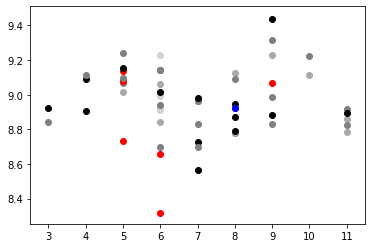

In [0]:

fig, ax = plt.subplots()

x_axis = 'TimeStamp_m'
y_axis = 'CompArrAvg_Mean'

print(f"Category = {category}")
plt.scatter(x_axis, y_axis,data=df_2014, color='lightgray') #Timestamp for 2014 is off. I'm thinking that TimeStamp is actually for the date it was added to the database and not the date of the event. World Archery got better about adding things regularly after 2015.
plt.scatter(x_axis, y_axis,data=df_2015, color='gray')
plt.scatter(x_axis, y_axis,data=df_2016, color='red')
plt.scatter(x_axis, y_axis,data=df_2017, color='darkgray')
plt.scatter(x_axis, y_axis,data=df_2018, color='black')
plt.scatter(x_axis, y_axis,data=df_2019, color='gray')
plt.scatter(x_axis, y_axis,data=rio_2016, color='blue', marker='o')

plt.show()

Category - RM


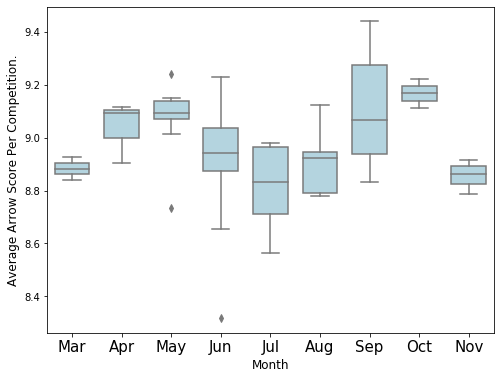

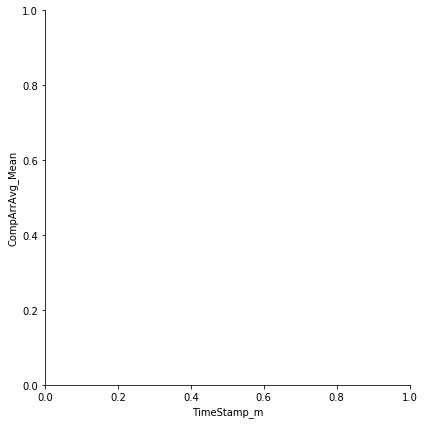

In [0]:
import seaborn as sns
df2015_2019 = df_2015 #combining all of the tables we have to see if there is a general trend.
for i in [df_2014, df_2016, df_2017, df_2018, df_2019]:
  df2015_2019 = df2015_2019.append(i)

fig1, ax1 = plt.subplots()

sns.catplot(kind='box', data=df2015_2019, x='TimeStamp_m', y='CompArrAvg_Mean', color='lightblue', height=6, width=0.7, ax=ax1)

fig1.set_size_inches(w=8, h=6)
fig1.set_facecolor(color='white')
ax1.set_facecolor(color='white')
ax1.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=15)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Average Arrow Score Per Competition.',fontsize=12)
#ax1.text(s='Rio 2016\nOlympics', x=4, y=8.9)
df2015_2019 = df2015_2019.sort_values(x_axis)
print(f"Category - {category}")
